### Human In the Loop

- Approval
- Debugging
- Editing

In [1]:
from dotenv import load_dotenv
import os 

load_dotenv()

from langchain_groq import ChatGroq 


os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="openai/gpt-oss-20b")

result = llm.invoke("Hello")
result

AIMessage(content='Hello! 👋 How can I help you today?', response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 72, 'total_tokens': 119, 'completion_time': 0.046057228, 'prompt_time': 0.034768132, 'queue_time': 0.049574808, 'total_time': 0.08082536, 'completion_tokens_details': {'reasoning_tokens': 27}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-826ea1ee-43c0-4b48-bd77-a24cc34a7fde-0', usage_metadata={'input_tokens': 72, 'output_tokens': 47, 'total_tokens': 119})

In [2]:
def add(a:int,b:int)->int:
    """ 
    Add a and b

    Args:
        a: first integer
        b: second integer
    """
    return a+b

def multiply(a:int,b:int)->int:
    """ 
    Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a*b 

def divide(a:int,b:int)->int:
    """ 
    Divide a and b.
    Args:
        a: first int
        b: second int
    """
    return a/b

tools = [add,multiply,divide]
llm_with_tools = llm.bind_tools(tools)

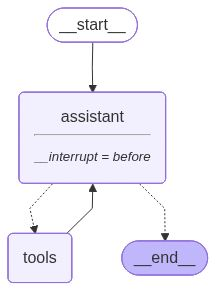

In [3]:
from IPython.display import Image,display 
from langgraph.checkpoint.memory import MemorySaver 
from langgraph.graph import MessagesState,add_messages
from langgraph.graph import START,StateGraph
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
from typing_extensions import TypedDict,Annotated

class State(TypedDict):
    messages: Annotated[list,add_messages]

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: State):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}

builder = StateGraph(State)

builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"assistant")
builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge("tools","assistant")

checkpointer = MemorySaver()
## Human in the loop
graph = builder.compile(interrupt_before=["assistant"],checkpointer=checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
initial_input = {
    "messages": HumanMessage(content="Multiply 2 and 3")
}
thread = {"configurable":{"thread_id":"1"}}

for event in graph.stream(initial_input,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [5]:
state = graph.get_state(thread)
state.next

('assistant',)

In [6]:
for event in graph.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (fc_cbf56624-7ade-4dbf-ae14-e69163abd845)
 Call ID: fc_cbf56624-7ade-4dbf-ae14-e69163abd845
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


### Edit Human Feedback

In [7]:
graph.update_state(thread,{"messages":[HumanMessage(content="No, Actually multiply 15 and 5")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0c9e86-9a3d-6fc0-8003-9b9718855be3'}}

In [8]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_cbf56624-7ade-4dbf-ae14-e69163abd845)
 Call ID: fc_cbf56624-7ade-4dbf-ae14-e69163abd845
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================ Human Message =================================

No, Actually multiply 15 and 5


In [9]:
for event in graph.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (fc_fbebbaef-15d4-4f1c-930b-a66fe769a6cc)
 Call ID: fc_fbebbaef-15d4-4f1c-930b-a66fe769a6cc
  Args:
    a: 15
    b: 5
================================= Tool Message =================================
Name: multiply

75


### Wait for an User Input

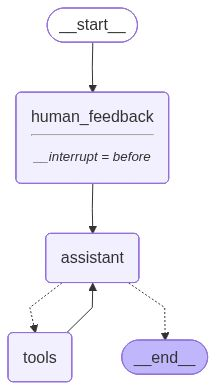

In [10]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def human_feedback(state:State):
    pass

def assistant(state: State):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}

builder = StateGraph(State)

builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_node("human_feedback",human_feedback)

builder.add_edge(START,"human_feedback")
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools","assistant")

memory = MemorySaver()

graph = builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
initial_input = {"messages":"Multiply 2 and 3"}

thread = {"configurable":{"thread_id":"5"}}

for event in graph.stream(initial_input,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

user_input = input("Tell me how you want to update the state")

graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

for event in graph.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_1e56ead0-9a48-4415-aed5-e5fe6a0cb430)
 Call ID: fc_1e56ead0-9a48-4415-aed5-e5fe6a0cb430
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: multiply

30
================================== Ai Message ==================================

30
